1. **Import Necessary Libraries**  
   Begin by importing the essential Python libraries required for data manipulation and file handling.

In [ ]:
# Import necessary libraries
import pandas as pd
import glob
import os

2. **Define the File Paths**  
   Specify the directories where your Parquet data files and `meta.pkl` files are stored. Adjust the paths according to your directory structure.

In [ ]:
# Path directories
data_dir = '/Users/a02428741/PycharmProjects/clyfar/data/obs'
meta_dir = '/Users/a02428741/PycharmProjects/clyfar/data/meta'

# Pattern to match Parquet files and meta.pkl files
data_pattern = os.path.join(data_dir, 'UB_obs_*.parquet')
meta_pattern = os.path.join(meta_dir, 'UB_obs_*_meta.pkl')


3. **Retrieve and Sort File Lists**  
   Use the `glob` module to retrieve lists of data and meta files. Sorting ensures that data and meta files correspond to the same years.

In [ ]:
# Retrieve sorted lists of data and meta files
data_files = sorted(glob.glob(data_pattern))
meta_files = sorted(glob.glob(meta_pattern))

# Print the number of files found
print(f"Found {len(data_files)} data files.")
print(f"Found {len(meta_files)} meta files.")

# Verify that the number of data and meta files match
if len(data_files) != len(meta_files):
    raise ValueError("Mismatch between the number of data and meta files.")

# Extract years from filenames to verify correspondence
def extract_year_data(filename):
    """
    Extracts the year from a data filename.
    Example: 'UB_obs_2005.parquet' -> '2005'
    """
    basename = os.path.basename(filename)
    parts = basename.split('_')
    year_part = parts[2]  # '2005.parquet'
    year = os.path.splitext(year_part)[0]
    return year

def extract_year_meta(filename):
    """
    Extracts the year from a meta filename.
    Example: 'UB_obs_2005_meta.pkl' -> '2005'
    """
    basename = os.path.basename(filename)
    parts = basename.split('_')
    year = parts[2]  # '2005'
    return year

data_years = [extract_year_data(f) for f in data_files]
meta_years = [extract_year_meta(f) for f in meta_files]

print(f"Data Years: {data_years}")
print(f"Meta Years: {meta_years}")

# Check if years match
if data_years != meta_years:
    raise ValueError("Data and meta files do not correspond to the same years.")
else:
    print("Data and meta files correspond correctly.")

4. **Read and Merge Data with Metadata**  
   Loop through each year's data and meta files, read them into pandas DataFrames, and merge them based on a common key (e.g., `station_id`). Adjust the `on` parameter according to your dataset's structure.

In [ ]:
merged_frames = []

for data_file, meta_file, year in zip(data_files, meta_files, data_years):
    print(f"\nProcessing Year: {year}")
    print(f"Data File: {data_file}")
    print(f"Meta File: {meta_file}")
    
    try:
        # Read the Parquet data
        df = pd.read_parquet(data_file)
        print(f"DataFrame shape: {df.shape}")
        
        # Read the meta.pkl
        meta = pd.read_pickle(meta_file)
        print(f"Meta type: {type(meta)}")
        
        # Determine the structure of meta and merge accordingly
        if isinstance(meta, pd.DataFrame):
            # Replace 'station_id' with your actual common key
            common_key = 'station_id'  # Change this if your key is different
            if common_key in df.columns and common_key in meta.columns:
                merged_df = pd.merge(df, meta, on=common_key, how='left')
                print(f"Merged DataFrame shape: {merged_df.shape}")
            else:
                print(f"Warning: '{common_key}' not found in both DataFrames. Skipping merge.")
                merged_df = df.copy()
        elif isinstance(meta, dict):
            # If meta is a dictionary, add its keys as new columns
            merged_df = df.copy()
            for key, value in meta.items():
                merged_df[key] = value
            print("Added meta dictionary keys as columns.")
        elif isinstance(meta, pd.Series):
            # If meta is a Series, convert it to DataFrame and merge
            meta_df = meta.reset_index()
            common_key = meta_df.columns[0]  # Assuming first column is the key
            if common_key in df.columns:
                merged_df = pd.merge(df, meta_df, on=common_key, how='left')
                print(f"Merged DataFrame shape: {merged_df.shape}")
            else:
                print(f"Warning: '{common_key}' not found in data DataFrame. Skipping merge.")
                merged_df = df.copy()
        else:
            # Handle other meta structures as needed
            print(f"Warning: Unexpected meta format ({type(meta)}). Skipping additional merge.")
            merged_df = df.copy()
        
        # Add a 'year' column if not already present
        if 'year' not in merged_df.columns:
            merged_df['year'] = int(year)
            print("Added 'year' column.")
        
        # Append the merged DataFrame to the list
        merged_frames.append(merged_df)
        
        print(f"Successfully merged data for year {year}.")
    
    except Exception as e:
        print(f"Error processing year {year}: {e}")
        continue  # Skip to the next file

In [ ]:
print(f"\nTotal merged DataFrames: {len(merged_frames)}")
if not merged_frames:
    print("No DataFrames were merged. Please check the previous steps for issues.")
else:
    print("Proceeding to concatenate the merged DataFrames.")

5. **Concatenate All Merged DataFrames**  
   Combine all the yearly merged DataFrames into a single comprehensive DataFrame using `pd.concat`.

In [ ]:
if merged_frames:
    full_data = pd.concat(merged_frames, ignore_index=True)
    print("All yearly data successfully concatenated into a single DataFrame.")
    print(full_data.head())
else:
    print("No DataFrames to concatenate.")

6. **Save the Merged DataFrame**  
   Save the consolidated DataFrame to disk for future use, either as a Parquet file or a pickle file.

In [ ]:
# Save the Merged DataFrame
save_path_parquet = '/Users/a02428741/PycharmProjects/clyfar/data/obs/full_weather_data.parquet'
save_path_pickle  = '/Users/a02428741/PycharmProjects/clyfar/data/meta/full_weather_data.pkl'

# Save as a single Parquet file
full_data.to_parquet(save_path_parquet, index=False)
print(f"Merged DataFrame saved successfully at {save_path_parquet}.")

# Or save as a pickle file
# full_data.to_pickle(save_path_pickle)
# print(f"Merged DataFrame saved successfully at {save_path_pickle}.")


**Loading from a Parquet File**

In [ ]:
import pandas as pd

# Define the path to your saved Parquet file
save_path_parquet = '/Users/a02428741/PycharmProjects/clyfar/data/obs/full_weather_data.parquet'

# Load the Parquet file into a DataFrame
full_data = pd.read_parquet(save_path_parquet)

# Inspect the DataFrame
print(full_data.info())

In [ ]:
print(full_data.dtypes)

In [ ]:
full_data.head(10)

In [ ]:
unique_stid = full_data['stid'].unique()
print(unique_stid)

In [ ]:
# Sort by 'stid' ascending and 'year' ascending
sorted_full_data = full_data.sort_values(by=['stid', 'year'], ascending=[True, True])

# Display the first few rows to verify
print(sorted_full_data.head())

In [ ]:
# Sort the DataFrame in place
full_data.sort_values(by=['stid', 'year'], ascending=[True, True], inplace=True)

# Verify the sorting
print(full_data.head())


/var/folders/g9/r745wyjd64gct_h61qq7z9dr0000gp/T/ipykernel_29174/2953108252.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = full_data.groupby(['year', 'stid'])['snow_depth'].mean().reset_index()
/var/folders/g9/r745wyjd64gct_h61qq7z9dr0000gp/T/ipykernel_29174/2953108252.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


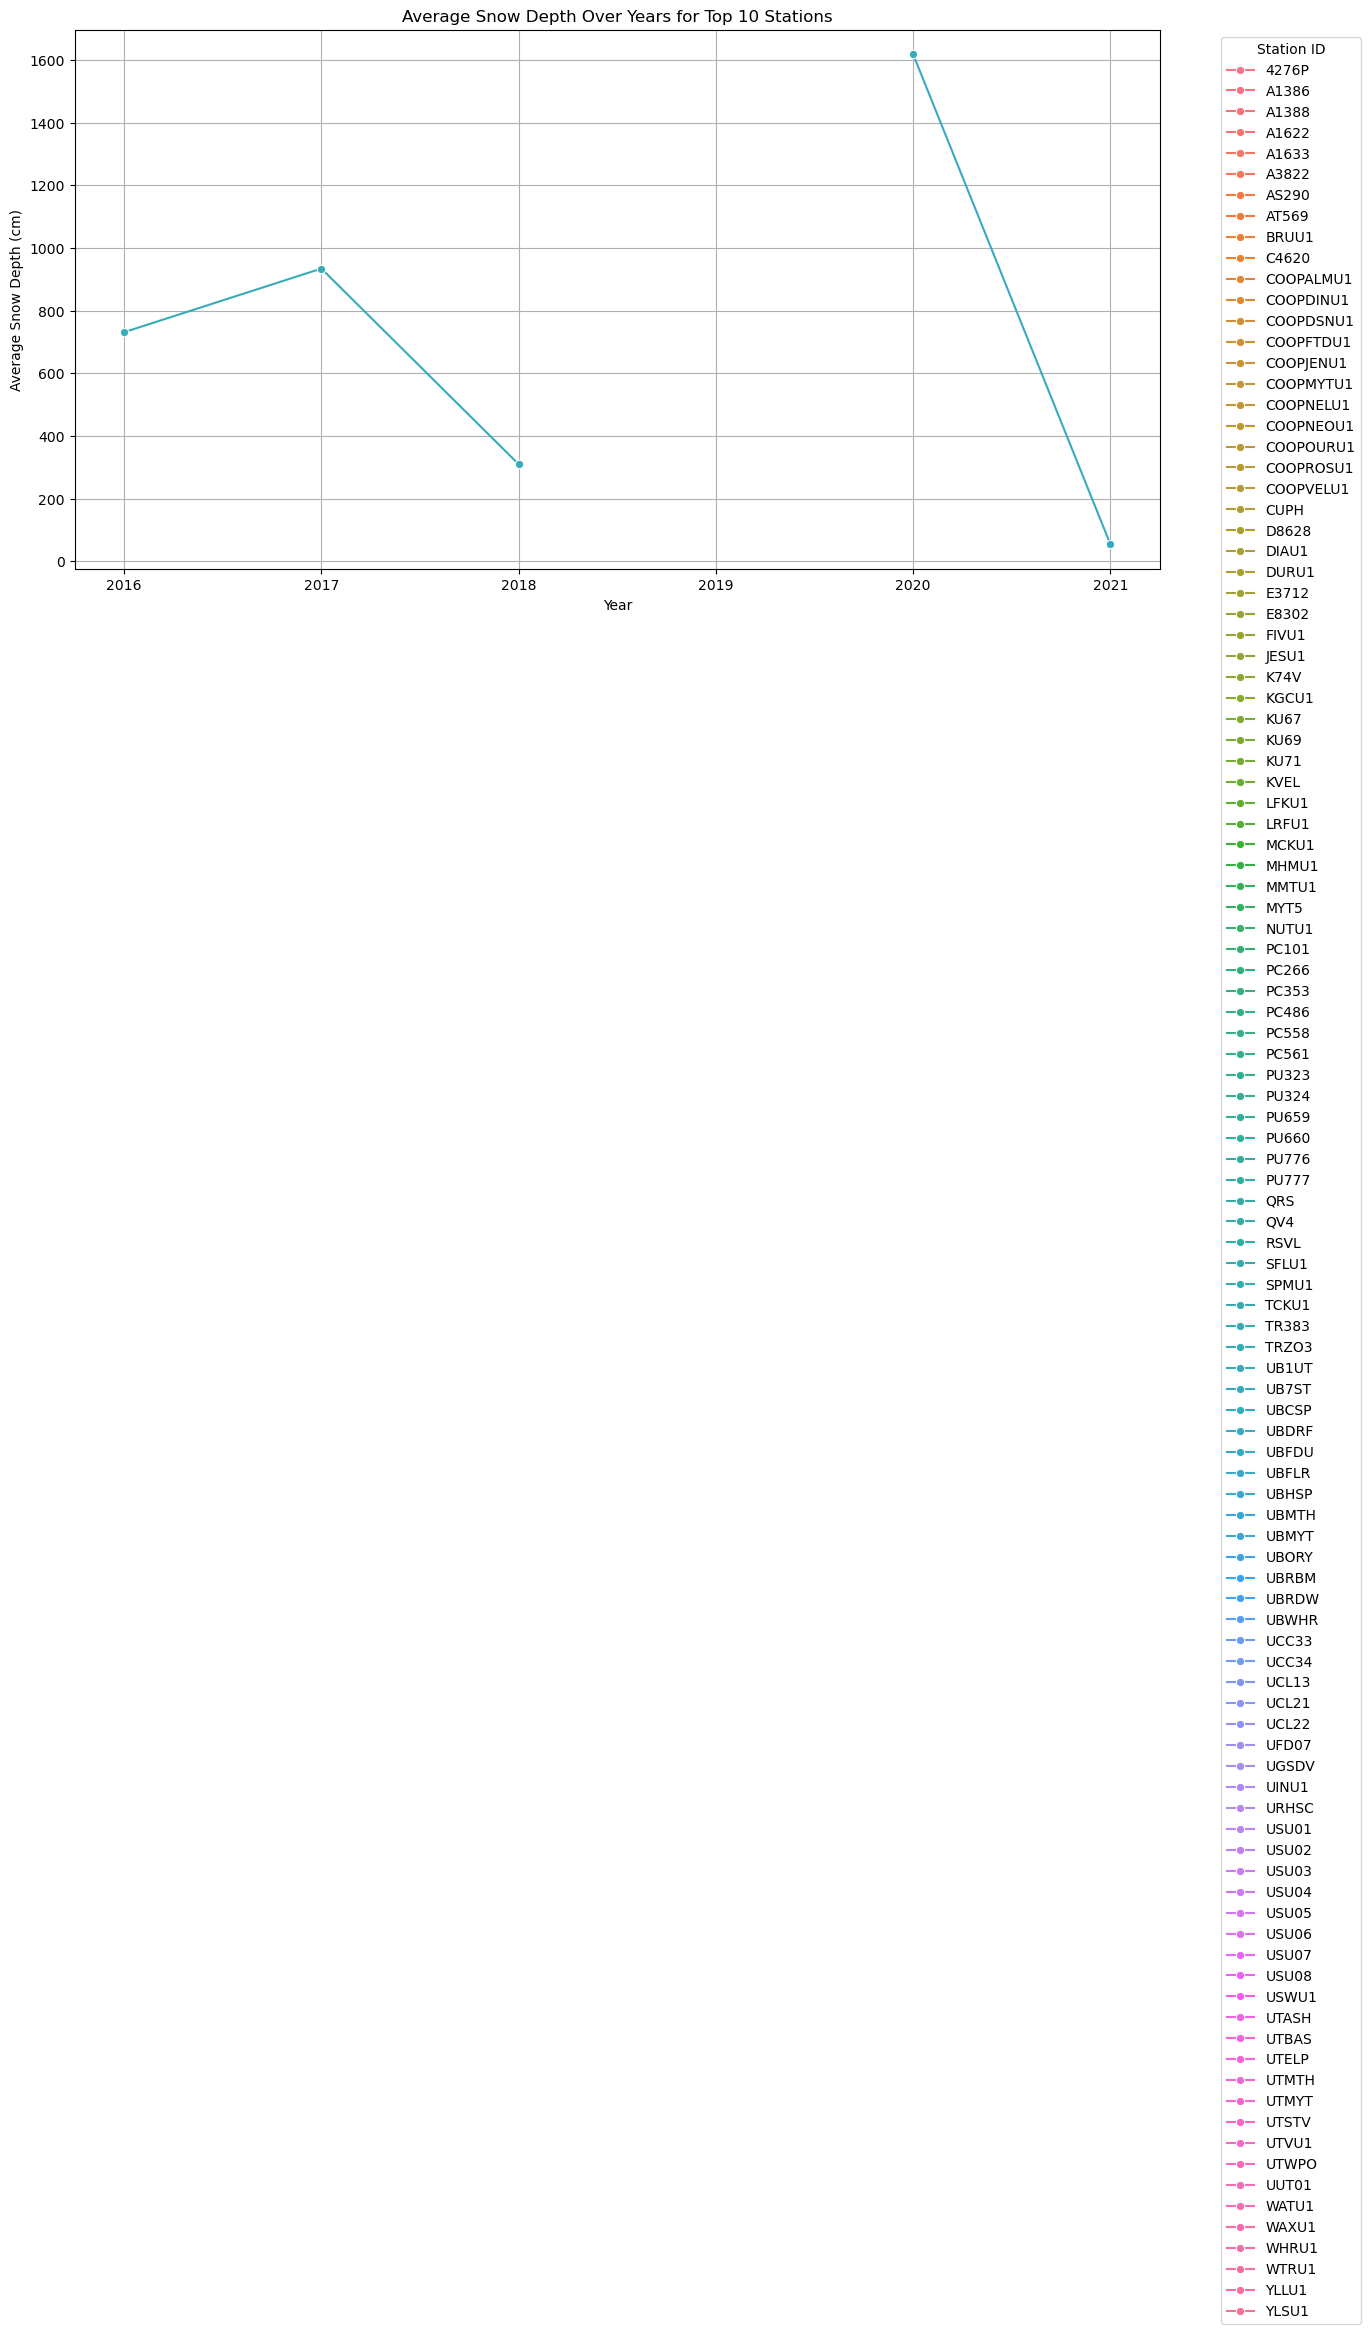

In [15]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate snow_depth by year and stid (average)
aggregated_data = full_data.groupby(['year', 'stid'])['snow_depth'].mean().reset_index()

# 2. Select top 10 stid based on total records
top_stids = full_data['stid'].value_counts().head(10).index.tolist()

# 3. Filter aggregated_data for top_stids
filtered_aggregated = aggregated_data[aggregated_data['stid'].isin(top_stids)]

# 4. Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_aggregated, x='year', y='snow_depth', hue='stid', marker='o')

# 5. Customize
plt.title('Average Snow Depth Over Years for Top 10 Stations')
plt.xlabel('Year')
plt.ylabel('Average Snow Depth (cm)')
plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# 6. Show plot
plt.show()

Top 10 Stations (by record count):
['YLLU1', 'UFD07', 'DURU1', 'E3712', 'WATU1', 'BRUU1', 'E8302', 'TRZO3', 'UB7ST', 'UBCSP']


/var/folders/g9/r745wyjd64gct_h61qq7z9dr0000gp/T/ipykernel_29174/1537344264.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


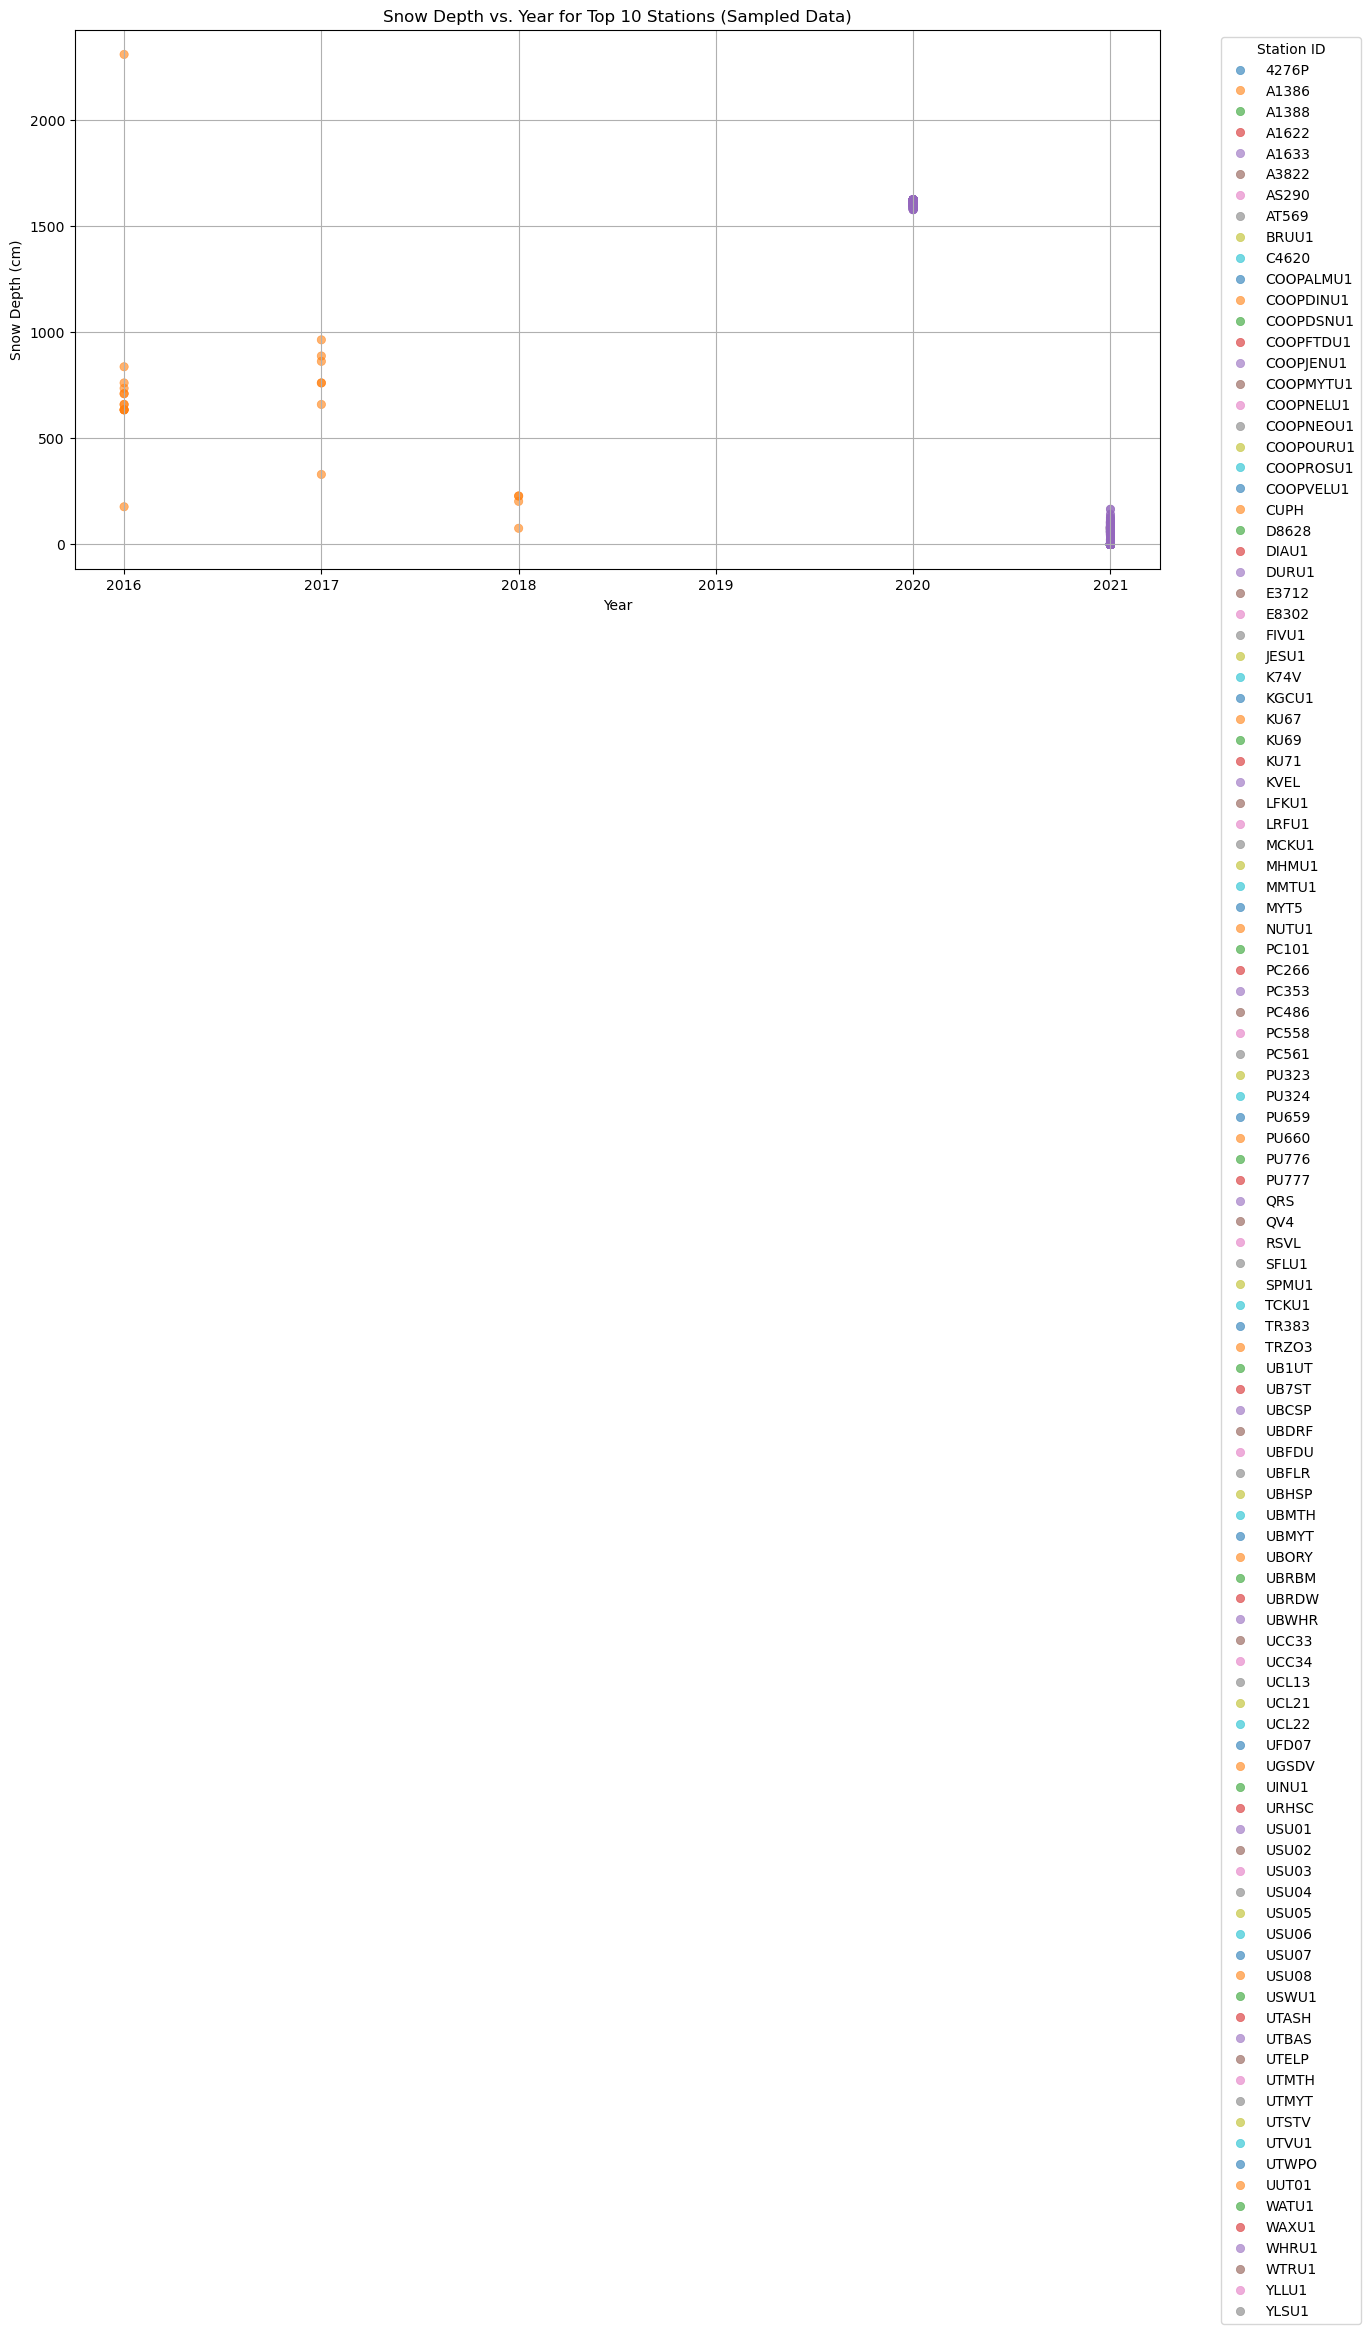

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify Top 10 Stations by Record Count
stid_counts = full_data['stid'].value_counts()
top_10_stids = stid_counts.head(10).index.tolist()
print("Top 10 Stations (by record count):")
print(top_10_stids)

# 2. Sample Data for Top 10 Stations
sample_size = 100000  # Adjust based on your system's capabilities
sampled_data = full_data[full_data['stid'].isin(top_10_stids)].sample(n=sample_size, random_state=42)

# 3. Plot Snow Depth vs. Year Colored by Station ID
plt.figure(figsize=(14, 7))
sns.scatterplot(data=sampled_data, x='year', y='snow_depth', hue='stid', palette='tab10', alpha=0.6, edgecolor=None)

# 4. Customize the Plot
plt.title('Snow Depth vs. Year for Top 10 Stations (Sampled Data)')
plt.xlabel('Year')
plt.ylabel('Snow Depth (cm)')
plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.grid(True)
plt.tight_layout()

# 5. Save the Plot to a File (Optional)
plt.savefig('snow_depth_top10_stations_scatter.png', dpi=300, bbox_inches='tight')

# 6. Display the Plot
plt.show()